In [135]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox

In [119]:
def ma_model(epsilon_prev, const, theta, sigma2):
    """ X_t = const + epsilon_t + theta * epsilon_{t-1} """

    epsilon_t = np.random.normal(loc=0, scale=np.sqrt(sigma2))
    next_logr = const + epsilon_t + theta * epsilon_prev

    return next_logr

# Round 1

In [120]:
price_0 = pd.read_csv('../data/raw/round_1/prices_round_1_day_-2.csv', delimiter=';')
price_1 = pd.read_csv('../data/raw/round_1/prices_round_1_day_-1.csv', delimiter=';')
price_2 = pd.read_csv('../data/raw/round_1/prices_round_1_day_0.csv', delimiter=';')

In [121]:
price_0 = price_0[price_0['product'] == 'KELP']
price_1 = price_1[price_1['product'] == 'KELP']
price_2 = price_2[price_2['product'] == 'KELP']

In [122]:
trades_0 = pd.read_csv('../data/raw/round_1/trades_round_1_day_-2.csv', delimiter=';')
trades_1 = pd.read_csv('../data/raw/round_1/trades_round_1_day_-1.csv', delimiter=';')
trades_2 = pd.read_csv('../data/raw/round_1/trades_round_1_day_0.csv', delimiter=';')

In [123]:
trades_0 = trades_0[trades_0['symbol'] == 'KELP']
trades_1 = trades_1[trades_1['symbol'] == 'KELP']
trades_2 = trades_2[trades_2['symbol'] == 'KELP']

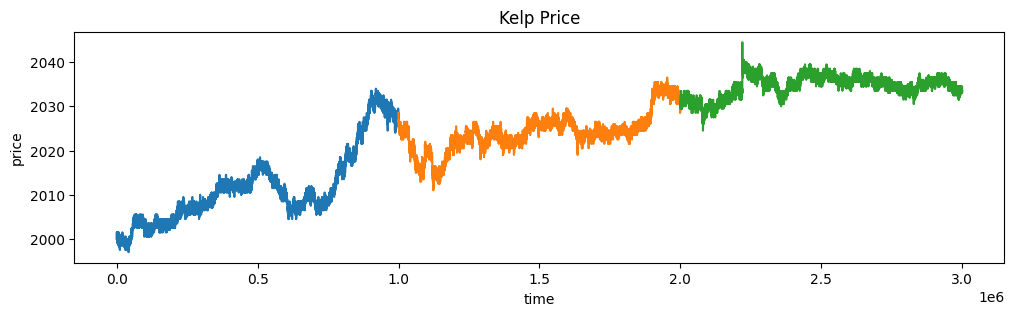

In [124]:
plt.figure(figsize=(12, 3))
plt.plot(price_0['timestamp'], price_0['mid_price'])
plt.plot(price_1['timestamp'] + 1000000, price_1['mid_price'])
plt.plot(price_2['timestamp'] + 2000000, price_2['mid_price'])
plt.title('Kelp Price')
plt.xlabel('time')
plt.ylabel('price')
plt.show()

In [125]:
prices = pd.concat([price_0, price_1, price_2], axis=0).reset_index(drop=True)
trades = pd.concat([trades_0, trades_1, trades_2], axis=0).reset_index(drop=True)

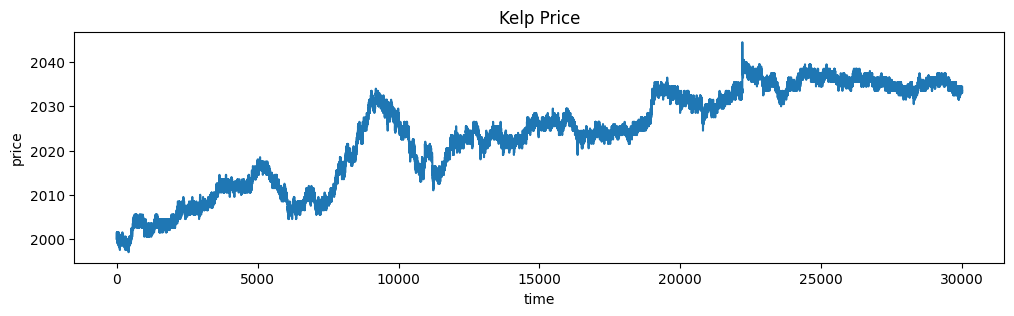

In [126]:
plt.figure(figsize=(12, 3))
plt.plot(prices['mid_price'])
plt.title('Kelp Price')
plt.xlabel('time')
plt.ylabel('price')
plt.show()

In [127]:
bid_prices = prices[['bid_price_1', 'bid_price_2', 'bid_price_3']].to_numpy()
max_inds = prices[['bid_volume_1', 'bid_volume_2', 'bid_volume_3']].idxmax(axis=1).apply(lambda x: int(x[-1]) - 1).to_numpy()
pop_bid_prices = bid_prices[np.arange(len(bid_prices)), max_inds]

ask_prices = prices[['ask_price_1', 'ask_price_2', 'ask_price_3']].to_numpy()
max_inds = prices[['ask_volume_1', 'ask_volume_2', 'ask_volume_3']].idxmax(axis=1).apply(lambda x: int(x[-1]) - 1).to_numpy()
pop_ask_prices = ask_prices[np.arange(len(ask_prices)), max_inds]

prices = prices.assign(pop_bid_price=pop_bid_prices)
prices = prices.assign(pop_ask_price=pop_ask_prices)
prices = prices.assign(pop_mid_price=(pop_bid_prices + pop_ask_prices) / 2)

In [128]:
price = prices.iloc[1000:1100]

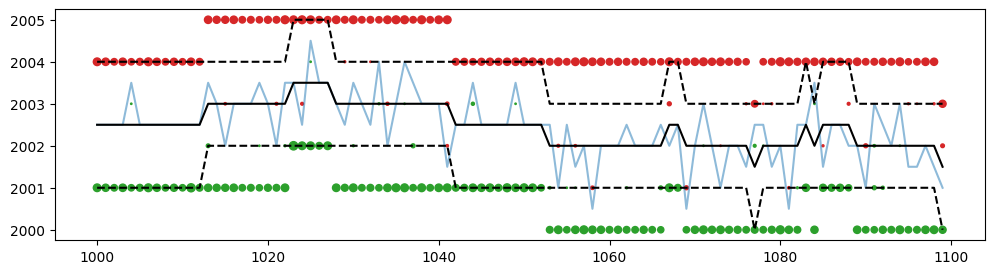

In [129]:
plt.figure(figsize=(12, 3))
plt.scatter(price['timestamp']//100, price['bid_price_1'], s=price['bid_volume_1'], c='tab:green')
plt.scatter(price['timestamp']//100, price['bid_price_2'], s=price['bid_volume_2'], c='tab:green')
plt.scatter(price['timestamp']//100, price['bid_price_3'], s=price['bid_volume_3'], c='tab:green')
plt.scatter(price['timestamp']//100, price['ask_price_1'], s=price['ask_volume_1'], c='tab:red')
plt.scatter(price['timestamp']//100, price['ask_price_2'], s=price['ask_volume_2'], c='tab:red')
plt.scatter(price['timestamp']//100, price['ask_price_3'], s=price['ask_volume_3'], c='tab:red')
plt.plot(price['timestamp']//100, price['mid_price'], c='tab:blue', alpha=0.5)
plt.plot(price['timestamp']//100, price['pop_mid_price'], c='k')
plt.plot(price['timestamp']//100, np.floor(price['pop_mid_price']) - 1, c='k', linestyle='dashed')
plt.plot(price['timestamp']//100, np.ceil(price['pop_mid_price']) + 1, c='k', linestyle='dashed')
plt.show()

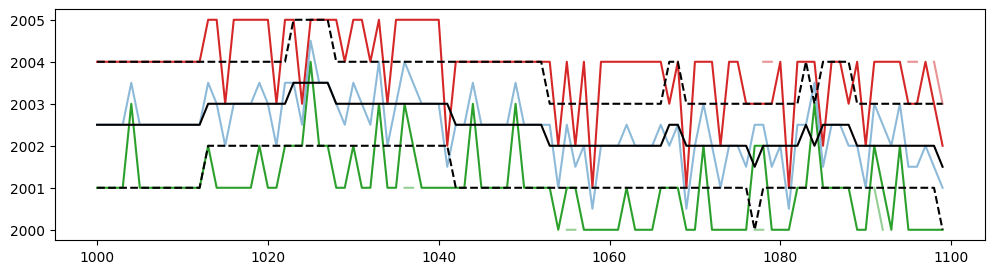

In [130]:
plt.figure(figsize=(12, 3))
plt.plot(price['timestamp']//100, price['bid_price_1'], c='tab:green')
plt.plot(price['timestamp']//100, price['bid_price_2'], c='tab:green', alpha=0.5)
plt.plot(price['timestamp']//100, price['bid_price_3'], c='tab:green', alpha=0.5)
plt.plot(price['timestamp']//100, price['ask_price_1'], c='tab:red')
plt.plot(price['timestamp']//100, price['ask_price_2'], c='tab:red', alpha=0.5)
plt.plot(price['timestamp']//100, price['ask_price_3'], c='tab:red', alpha=0.5)
plt.plot(price['timestamp']//100, price['mid_price'], c='tab:blue', alpha=0.5)
plt.plot(price['timestamp']//100, price['pop_mid_price'], c='k')
plt.plot(price['timestamp']//100, np.floor(price['pop_mid_price']) - 1, c='k', linestyle='dashed')
plt.plot(price['timestamp']//100, np.ceil(price['pop_mid_price']) + 1, c='k', linestyle='dashed')
plt.show()

## Price prediction - popular mid price

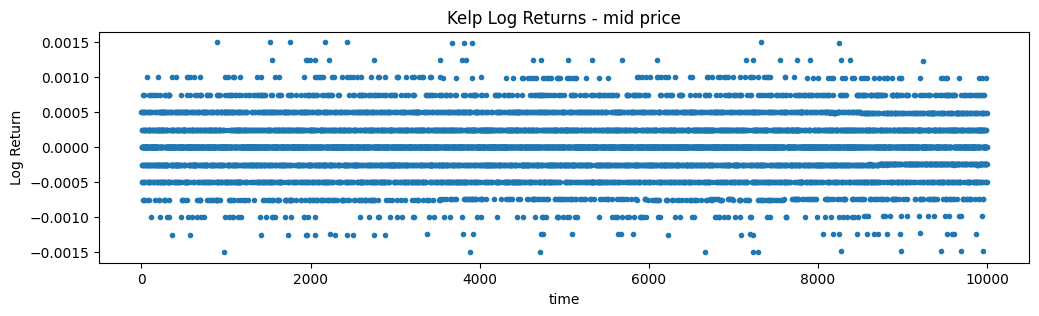

In [136]:
train = prices['mid_price'].iloc[:prices.shape[0] // 3].to_numpy()
valid = prices['mid_price'].iloc[prices.shape[0] // 3:prices.shape[0] // 3 * 2].to_numpy()
test = prices['mid_price'].iloc[prices.shape[0] // 3 * 2:].to_numpy()

train_logr = np.log(train[1:] / train[:-1])
valid_logr = np.log(valid[1:] / valid[:-1])
test_logr = np.log(test[1:] / test[:-1])

plt.figure(figsize=(12, 3))
plt.scatter(np.arange(len(train_logr)), train_logr, marker='.')
plt.title('Kelp Log Returns - mid price')
plt.xlabel('time')
plt.ylabel('Log Return')
plt.show()

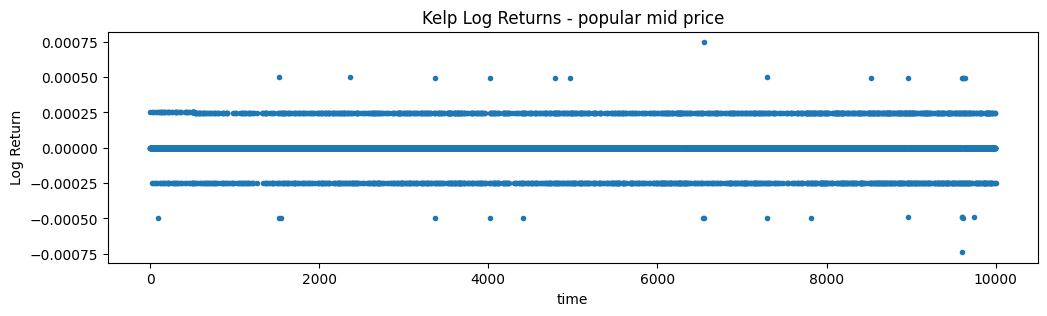

In [137]:
train = prices['pop_mid_price'].iloc[:prices.shape[0] // 3].to_numpy()
valid = prices['pop_mid_price'].iloc[prices.shape[0] // 3:prices.shape[0] // 3 * 2].to_numpy()
test = prices['pop_mid_price'].iloc[prices.shape[0] // 3 * 2:].to_numpy()

train_logr = np.log(train[1:] / train[:-1])
valid_logr = np.log(valid[1:] / valid[:-1])
test_logr = np.log(test[1:] / test[:-1])

plt.figure(figsize=(12, 3))
plt.scatter(np.arange(len(train_logr)), train_logr, marker='.')
plt.title('Kelp Log Returns - popular mid price')
plt.xlabel('time')
plt.ylabel('Log Return')
plt.show()

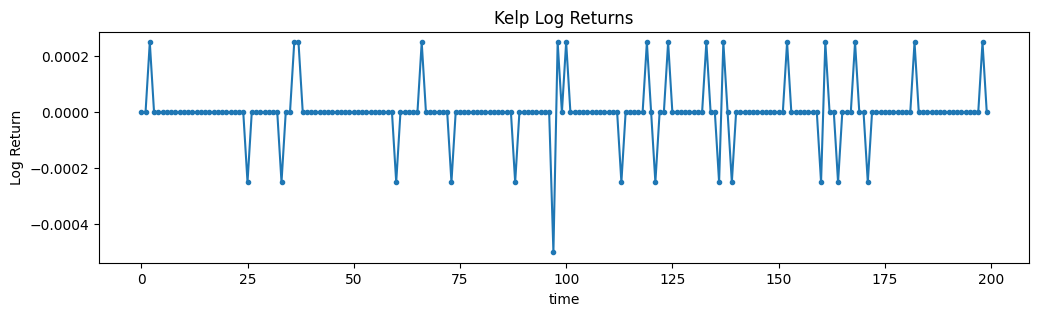

In [138]:
plt.figure(figsize=(12, 3))
plt.plot(np.arange(len(train_logr[:200])), train_logr[:200], marker='.')
plt.title('Kelp Log Returns')
plt.xlabel('time')
plt.ylabel('Log Return')
plt.show()

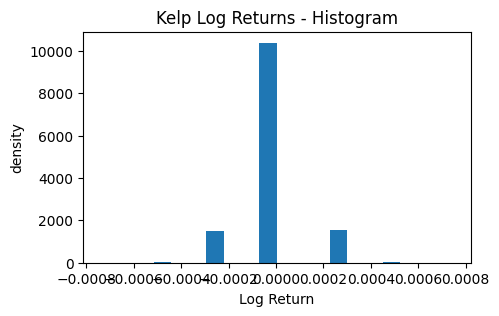

In [139]:
plt.figure(figsize=(5, 3))
plt.hist(train_logr, bins=20, density=True)
plt.title('Kelp Log Returns - Histogram')
plt.xlabel('Log Return')
plt.ylabel('density')
plt.show()

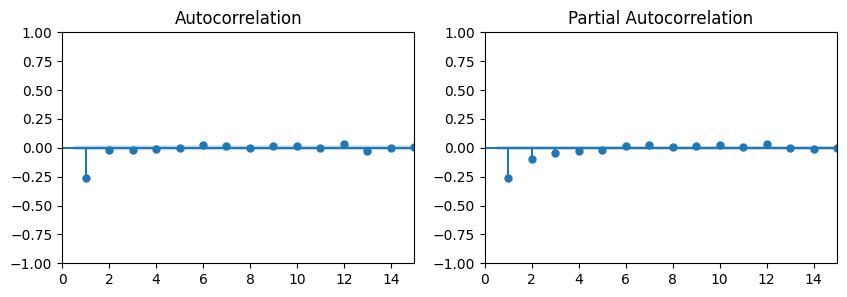

In [140]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
plot_acf(train_logr, ax=ax[0], zero=False)
plot_pacf(train_logr, ax=ax[1], zero=False)
ax[0].set_xlim([0, 15])
ax[1].set_xlim([0, 15])
plt.show()

In [141]:
# Perform Ljung-Box test for lags up to 10
result = acorr_ljungbox(train_logr, lags=[10], return_df=True)
print(result)

# Interpretation
if result['lb_pvalue'].values[0] > 0.05:
    print("Fail to reject null hypothesis: data may be white noise.")
else:
    print("Reject null hypothesis: data is not white noise.")

       lb_stat      lb_pvalue
10  701.837954  2.531660e-144
Reject null hypothesis: data is not white noise.


### Naive

In [62]:
rmse = np.mean(valid_logr ** 2) ** 0.5
print(f'Log-returns RMSE: {rmse}')

y = valid[1:]
y_pred = valid[:-1]
err = y - y_pred
rmse = np.mean(err ** 2) ** 0.5
print(f'Price RMSE: {rmse}')

Log-returns RMSE: 0.00013231476377939335
Price RMSE: 0.267735257702122


In [147]:
rmse = np.mean(test_logr ** 2) ** 0.5
print(f'Log-returns RMSE - test set: {rmse}')

y = test[1:]
y_pred = test[:-1]
err = y - y_pred
rmse = np.mean(err ** 2) ** 0.5
print(f'Price RMSE - test set: {rmse}')

Log-returns RMSE - test set: 0.00012116630086041733
Price RMSE - test set: 0.24663958139015488


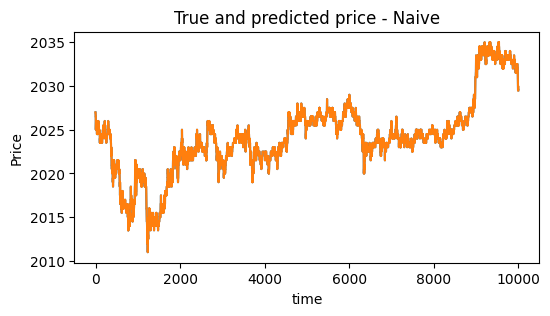

In [53]:
plt.figure(figsize=(6, 3))
plt.plot(y)
plt.plot(y_pred)
plt.title('True and predicted price - Naive')
plt.xlabel('time')
plt.ylabel('Price')
plt.show()

### MA(1)

In [148]:
model = ARIMA(train_logr, order=(0, 0, 1))
result = model.fit()
print(result.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 9999
Model:                 ARIMA(0, 0, 1)   Log Likelihood               76386.615
Date:                Tue, 08 Apr 2025   AIC                        -152767.229
Time:                        11:33:42   BIC                        -152745.599
Sample:                             0   HQIC                       -152759.907
                               - 9999                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.366e-06   8.26e-07      1.653      0.098   -2.53e-07    2.98e-06
ma.L1         -0.2909    4.9e-12  -5.93e+10      0.000      -0.291      -0.291
sigma2      1.355e-08   1.41e-10     96.457      0.0

C:\Users\aeali\PycharmProjects\imc-prosperity-3\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [149]:
result.params

array([ 1.36576922e-06, -2.90930602e-01,  1.35539686e-08])

In [150]:
errs = [valid_logr[0] - 0]
preds = [0]
for i in range(1, len(valid_logr)):
    pred = ma_model(epsilon_prev=errs[i-1], const=result.params[0], theta=result.params[1], sigma2=result.params[2])
    err = test_logr[i] - pred
    preds.append(pred)
    errs.append(err)

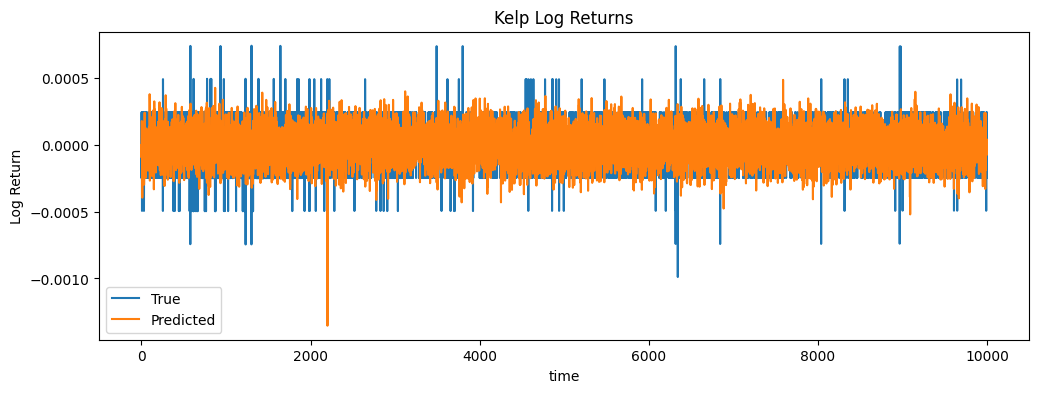

In [151]:
plt.figure(figsize=(12, 4))
plt.plot(valid_logr, label='True')
plt.plot(preds, label='Predicted')
plt.title('Kelp Log Returns')
plt.xlabel('time')
plt.ylabel('Log Return')
plt.legend()
plt.show()

In [152]:
pred_price = valid[:-1] * np.exp(preds)

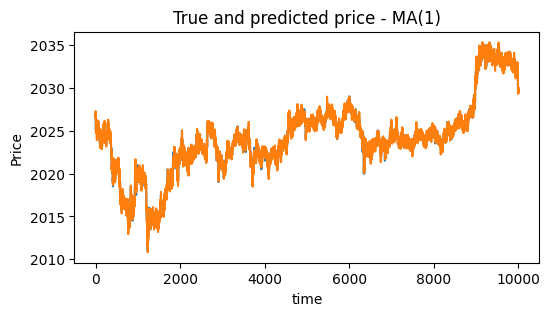

In [153]:
plt.figure(figsize=(6, 3))
plt.plot(valid[1:])
plt.plot(pred_price)
plt.title('True and predicted price - MA(1)')
plt.xlabel('time')
plt.ylabel('Price')
plt.show()

In [154]:
err = valid_logr - preds
rmse = np.mean(err ** 2) ** 0.5
print(f'Log-returns RMSE: {rmse}')

err = valid[1:] - pred_price
rmse = np.mean(err ** 2) ** 0.5
print(f'Price RMSE: {rmse}')

Log-returns RMSE: 0.00018327900292343594
Price RMSE: 0.3709116311168852


### AR(1)

In [155]:
coeffs = np.polyfit(train_logr[:-1], train_logr[1:], deg=1)
a, b = coeffs

In [156]:
print(a, b)

-0.2620219858049914 1.7302653799072463e-06


In [157]:
preds = valid_logr[:-1] * -0.262

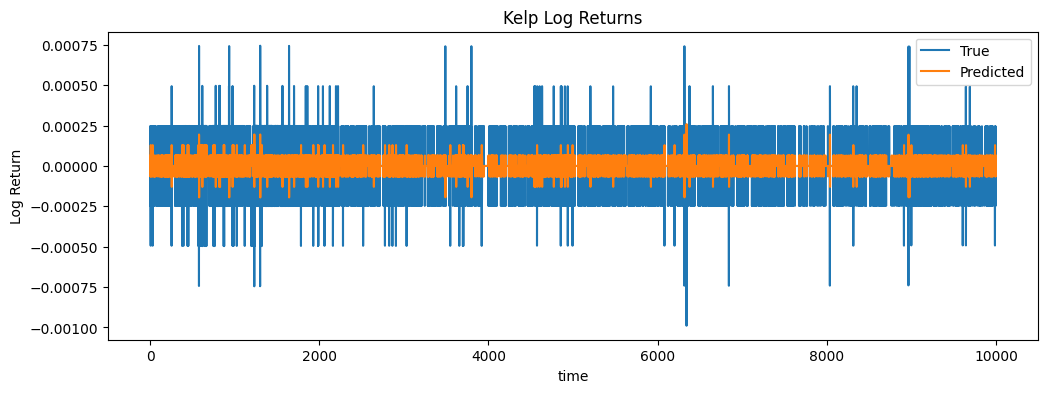

In [160]:
plt.figure(figsize=(12, 4))
plt.plot(valid_logr[1:], label='True')
plt.plot(preds, label='Predicted')
plt.title('Kelp Log Returns')
plt.xlabel('time')
plt.ylabel('Log Return')
plt.legend()
plt.show()

In [161]:
pred_price = valid[1:-1] * np.exp(preds)

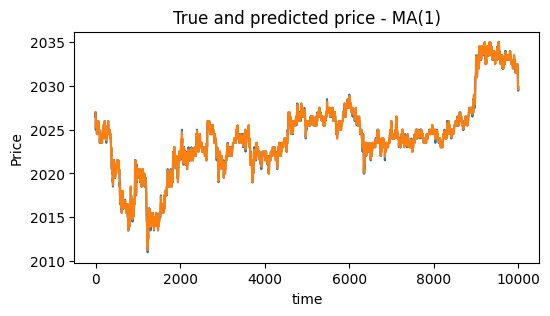

In [162]:
plt.figure(figsize=(6, 3))
plt.plot(valid[2:])
plt.plot(pred_price)
plt.title('True and predicted price - MA(1)')
plt.xlabel('time')
plt.ylabel('Price')
plt.show()

In [163]:
err = valid_logr[1:] - preds
rmse = np.mean(err ** 2) ** 0.5
print(f'Log-returns RMSE: {rmse}')

err = valid[2:] - pred_price
rmse = np.mean(err ** 2) ** 0.5
print(f'Price RMSE: {rmse}')

Log-returns RMSE: 0.00012814350483993526
Price RMSE: 0.25928564082602307


-> Selected model: AR(1)

In [164]:
preds = test_logr[:-1] * -0.262

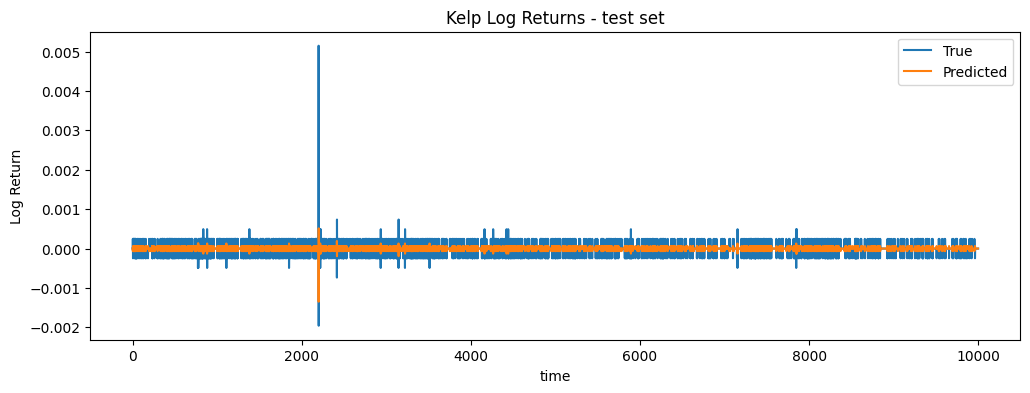

In [165]:
plt.figure(figsize=(12, 4))
plt.plot(test_logr, label='True')
plt.plot(preds, label='Predicted')
plt.title('Kelp Log Returns - test set')
plt.xlabel('time')
plt.ylabel('Log Return')
plt.legend()
plt.show()

In [166]:
pred_price = test[1:-1] * np.exp(preds)

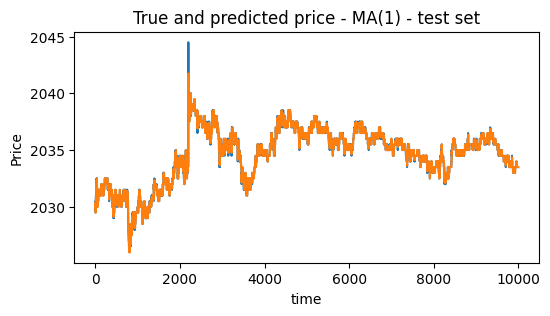

In [167]:
plt.figure(figsize=(6, 3))
plt.plot(test[2:])
plt.plot(pred_price)
plt.title('True and predicted price - MA(1) - test set')
plt.xlabel('time')
plt.ylabel('Price')
plt.show()

In [168]:
err = test_logr[1:] - preds
rmse = np.mean(err ** 2) ** 0.5
print(f'Log-returns RMSE - test set: {rmse}')

err = test[2:] - pred_price
rmse = np.mean(err ** 2) ** 0.5
print(f'Price RMSE - test set: {rmse}')

Log-returns RMSE - test set: 0.00011605321420694254
Price RMSE - test set: 0.23622145924467564
